*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/yqtl_association_with_advb.ipynb)*

<center><h1>Yiqṭol and Its Association with Prototypical Adverbs</h1></center>
<center><h3 style="font-weight:normal">Cody Kingham</h3></center>
<center><h2><a href="../../docs/sponsors.md"><img height=20% width=20% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [3]:
! echo "last updated:"; date

last updated:
Wed 29 Jan 2020 17:50:49 GMT


## Why does yiqṭol prefer particles?

In [a preliminary analysis](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/archive/2019-10-31/analysis/exploratory/construction_clusters.ipynb), we found evidence that the yiqṭol verb tends to be attracted to time words which can be considered "prototypical adverbs". For instance, the analysis found a statistical attraction with words like אז ,נצח ,עולם ,מתי ,עתה — words that are sometimes refered to as "particles" in the grammars (i.e. function words).

In [the recent study on parts of speech](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/time_distribution_and_pos.ipynb), we found an empirical basis for separating words like these on the grounds of their collocability with constructions that indicate number, definiteness, or possession. This behavior is not an absolute rule, but rather a generalization. Some words, like עולם, fall squarely into the region of "adverb" when plotted on a graph, and yet are occasionally paired with nominalizing constructions (cases of construal). But the behavior is distinct enough to distinguish separate clusters amongst the terms.

**In this notebook, we show that yiqṭol indeed has a preference for these adverb terms, and we ask why?**

### Why does it matter?

One of the surprising things about this pattern, as this notebook will demonstrate, is that not all of the yiqṭol adverbs seem to fit the same semantic mold. For instance, the word אז, which seemingly refers to a point in time, is wholly different from עולם, which refers to a unknown duration. And yet, these words share two major qualities: they are both adverb-like, and they both strongly prefer the yiqṭol verb (as we will show). On the face of it, we might assume that yiqṭol's preference is primarily semantic in nature: durational terms such as עולם and נצח would fit the unbounded nature of the verbal form, on which most scholars agree. But אז suggests another possibility: that yiqṭol's preference is not wholly predictable from its semantics, but possibly due to a convention of use. Or, in other words, it is simply an idiosyncratic quality of yiqṭol to easily combine with adverbs. This would not mean such behavior has *no* semantic motivation. Perhaps the association of yiqṭol with durational adverbs opened the door for an association with adverbs in general. **These questions are purely hypothetical. And in this notebook we will seek to find empirical data that can help (in)validate these hypotheses and suggest further directions for analysis.**

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [2]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom package in /tools
from paths import figs
from helpers import Figures, convert2pandas
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())
sns.set(font_scale=1.5, style='whitegrid')

## Data Output

In [3]:
fg = Figures()

In [4]:
chapter = 'yiqtol_and_propcxs'
figures = figs.joinpath(chapter)
if not figures.exists():
    figures.mkdir(parents=True)
    
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name, sep='.'))

### Collocation with Nominalizing Constructions

*Description here*

In [5]:
single_tas = class2cx['single'] - class2cx['component']

print(f'Number of single time adverbials: {len(single_tas)}')

Number of single time adverbials: 3823


In [8]:
# map to head lexemes here
tense2count = collections.defaultdict(lambda:collections.Counter())
contexts = collections.defaultdict(lambda:collections.defaultdict(list))
head2tense = collections.defaultdict(lambda:collections.Counter())

# apply filters to the tas, co
for ta in single_tas:
    
    head = list(ta.getsuccroles('head'))[-1] # head selected from graph
    head_cx = next(iter(ta.graph.pred[head]))
    clause = L.u(head, 'clause')[0]
    verb = next(iter(w for w in L.d(clause,'word') if F.pdp.v(w) == 'verb'), None)
    tense =  F.vt.v(verb) or ''
    tense = {'ptca': 'ptcp'}.get(tense, tense) # remap ptca label
    
    # apply exclusions / filter
    if any([
        F.sp.v(head) == 'verb',
        not verb,
        tense.startswith('inf'),
        tense == 'impv'
    ]): continue
    
    # make the collocation counts
    nominal_markers = {
        'pl.': F.nu.v(head) == 'pl',
        'card.': (
            'cardinal' in ta.classification 
            or F.nu.v(head) == 'du'
        ),
        'qquant.': 'qualitative' in ta.classification,
        'defi.': 'definite' in ta.classification,
        'demon.': 'demonstrative' in ta.classification,
        'geni.': 'genitive' in ta.classification,
    }
    
    if not any(nominal_markers.values()):
        nominal_counts = {'ø': 1}
    else:
        nominal_counts = {
            tag:(1 if cond else 0) for tag, cond in nominal_markers.items()
        }
    
    tense2count[tense].update(nominal_counts)
    head2tense[F.lex_utf8.v(head)][tense] += 1
    for tag, cond in nominal_counts.items():
        if cond:
            contexts[tense][tag].append(ta)
    
tense_cols = pd.DataFrame.from_dict(tense2count, orient='index').fillna(0)
tense_cols = tense_cols.loc[tense_cols.sum(1).sort_values(ascending=False).index].T # sort by row-sum
head2tense = pd.DataFrame.from_dict(head2tense, orient='index').fillna(0)

print(tense_cols.shape)

(7, 5)


In [12]:
head2tense['yqṭl'].sort_values(ascending=False).head(50)

יום       329.0
עוד       198.0
עולם       77.0
אז         72.0
עתה        44.0
עת         42.0
שׁנה       36.0
ערב        29.0
בקר        27.0
אחר        26.0
מחר        20.0
נצח        20.0
תמיד       18.0
כן         18.0
מתי        16.0
פעם        14.0
לילה       14.0
פתאם       12.0
אן         11.0
עד         11.0
טרם         9.0
יומם        8.0
רגע         7.0
צהרים       6.0
חדשׁ        6.0
שׁבע        4.0
אחרון       4.0
מות         4.0
חיים        3.0
מועד        3.0
שׁבוע       3.0
מהרה        3.0
שׁני        2.0
מחרת        2.0
שׂיבה       2.0
שׁביעי      2.0
טהרה        2.0
אחרית       2.0
חצות        2.0
דור         2.0
שׁבת        1.0
דבר         1.0
ראשׁון      1.0
רגל         1.0
זאת         1.0
פנה         1.0
הנה         1.0
אור         1.0
מלכות       1.0
שׁמים       1.0
Name: yqṭl, dtype: float64

The top of each dataset is seen below.

In [7]:
tense_cols.head()

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,601,241,142,47,74
pl.,156,170,134,44,22
card.,96,119,127,37,3
qquant.,59,45,38,11,15
defi.,276,287,317,98,95


## Ratios

In [8]:
tense_col_ratio = tense_cols.div(tense_cols.sum(0), axis=1)

tense_col_ratio

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,0.427150,0.216922,0.145046,0.158784,0.293651
pl.,0.110874,0.153015,0.136874,0.148649,0.087302
card.,0.068230,0.107111,0.129724,0.125000,0.011905
qquant.,0.041933,0.040504,0.038815,0.037162,0.059524
defi.,0.196162,0.258326,0.323800,0.331081,0.376984
demon.,0.069652,0.124212,0.166496,0.128378,0.063492
geni.,0.085999,0.099910,0.059244,0.070946,0.107143


## Fisher's 

In [38]:
tense_assoc = apply_fishers(tense_cols)
tense_assoc.head(7)

,yqṭl,qṭl,wyqṭl,wqṭl,ptcp
ø,55.513892,-6.213832,-26.464074,-5.734757,0.332089
pl.,-2.094814,2.056635,0.320502,0.490112,-1.380899
card.,-4.556366,1.036625,4.604266,1.106499,-7.366472
qquant.,0.029577,-0.031675,-0.147004,-0.055855,0.849350
defi.,-12.700860,-0.259848,5.590342,2.032989,4.197517
demon.,-9.873934,0.880266,8.641801,0.469475,-2.013878
geni.,0.169568,1.657379,-2.850269,-0.290707,0.798601


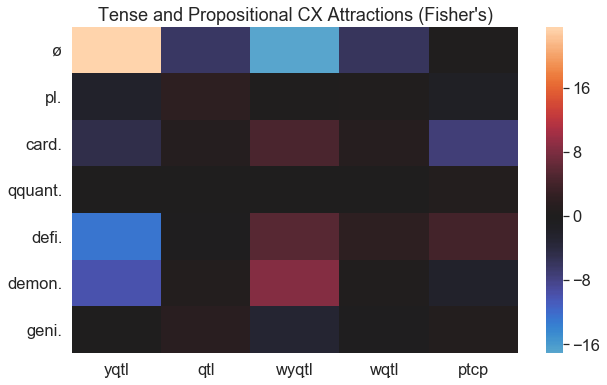

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(tense_assoc, center=0, robust=True)
plt.yticks(rotation=0)
plt.savefig(fg_path('tense_propcx_attractions.png'), dpi=300, bbox_inches='tight')
plt.title('Tense and Propositional CX Attractions (Fisher\'s)')
plt.show()

### ΔP Asymmetrical Tests

> "􏰁P is the probability of the outcome given the cue P(O|C) minus the probability of the outcome in the absence of the cue P(O|–C). When these are the same, when the outcome is just as likely when the cue is present as when it is not, there is no covariation between the two events and 􏰁P 1⁄4 0. 􏰁P approaches 1.0 as the presence of the cue increases the likelihood of the outcome and approaches –1.0 as the cue decreases the chance of the outcome—a negative association." -Ellis, "Language Acquisition," 2006, 11.

**NB: The following code needs to be checked over.**

#### Propositional CX as cue

In [42]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# cx_cue = dp_a / (dp_a + dp_c) - dp_b / (dp_b + dp_d)

In [43]:
# cx_cue

#### Verb as Cue

In [44]:
# # unidirectional ΔP test
# con = contingency_table(tense_cols)
# dp_a, dp_b, dp_c, dp_d = [con[x] for x in ('a', 'b', 'c', 'd')]
# verb_cue = dp_a / (dp_a + dp_b) - dp_c / (dp_c + dp_d)

In [45]:
# verb_cue

## Adverbs

In [35]:
advb = head_components[head_components['PC1'] < 0].iloc[:, :2]

advb

,PC1,PC2
time,,
עתה,-0.560272,0.034554
עוד,-0.554259,0.031588
עולם,-0.509187,0.028194
אז,-0.565636,0.035266
כן,-0.565636,0.035266
תמיד,-0.565636,0.035266
מחר,-0.565636,0.035266
נצח,-0.526004,0.026760
מחרת,-0.310113,0.017393


#### Have a look at their tense tendencies

First we build a table, `tense_cols` which contains tense collocation counts.

In [40]:
tense_cols = times.pivot_table(index=['time'], columns=['tense'], aggfunc='size').fillna(0)
tense_cols = tense_cols[['qtl', 'wqtl', 'wyqtl', 'yqtl', 'ptcp',]]
tense_cols = tense_cols.loc[tense_cols.sum(1).sort_values(ascending=False).index]

In [41]:
tense_cols.head()

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
יום,331.0,96.0,257.0,329.0,89.0
עוד,42.0,8.0,48.0,198.0,24.0
שׁנה,99.0,11.0,67.0,36.0,3.0
עולם,23.0,19.0,6.0,77.0,9.0
עת,29.0,6.0,31.0,42.0,12.0


#### Select tenses collocated with "adverbs"

In [42]:
advb_tenses = tense_cols.loc[advb.index]

advb_tenses

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
עתה,45.0,0.0,0.0,44.0,2.0
עוד,42.0,8.0,48.0,198.0,24.0
עולם,23.0,19.0,6.0,77.0,9.0
אז,43.0,0.0,1.0,72.0,3.0
כן,11.0,0.0,21.0,18.0,0.0
תמיד,2.0,6.0,0.0,18.0,6.0
מחר,1.0,1.0,0.0,20.0,4.0
נצח,4.0,0.0,0.0,20.0,1.0
מחרת,0.0,0.0,21.0,2.0,0.0


#### Association with given times

In [43]:
advb_time_assoc = apply_fishers(advb_tenses)

advb_time_assoc

,qtl,wqtl,wyqtl,yqtl,ptcp
עתה,10.188920,-1.559353,-5.019724,-1.023170,-0.792684
עוד,-4.325592,-1.338382,1.342952,1.414793,0.698334
עולם,-0.447819,6.223937,-2.614646,-0.000000,0.155978
אז,4.557429,-2.167975,-5.529125,0.365672,-1.000539
כן,0.140994,-0.789953,7.570195,-2.524559,-1.174050
תמיד,-1.356638,2.694969,-1.597511,0.000000,1.991088
מחר,-1.563245,0.000000,-1.205471,1.354208,1.171812
נצח,-0.095910,-0.205991,-1.207862,1.639111,0.000000
מחרת,-2.124708,-0.207926,17.804566,-5.873959,-0.407049
מתי,-0.399334,0.000000,-0.807501,1.394127,0.461127


#### Look at strong statistical (dis)associations with yiqtol

In [45]:
pd.DataFrame(advb_time_assoc['yqtl'][advb_time_assoc['yqtl'] > 1.3])

,yqtl
עוד,1.414793
מחר,1.354208
נצח,1.639111
מתי,1.394127


In [46]:
pd.DataFrame(advb_time_assoc['yqtl'][advb_time_assoc['yqtl'] < -1.3])

,yqtl
כן,-2.524559
מחרת,-5.873959
שׁני,-3.700727
מהר,-1.330934


#### Ratio Across All "adverbs"

In [47]:
advb_tenses.sum() / advb_tenses.sum().sum()

tense
qtl      0.204943
wqtl     0.044284
wyqtl    0.119464
yqtl     0.570546
ptcp     0.060762
dtype: float64

Here ^ we see that nearly 60% of these adverb uses are collocations with yiqṭol. How does that compare with the rest?

#### Observe average across all adverbs

In [48]:
advb_tense_avg = advb_tenses.div(advb_tenses.sum(1), axis=0)

advb_tense_avg

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
עתה,0.494505,0.000000,0.000000,0.483516,0.021978
עוד,0.131250,0.025000,0.150000,0.618750,0.075000
עולם,0.171642,0.141791,0.044776,0.574627,0.067164
אז,0.361345,0.000000,0.008403,0.605042,0.025210
כן,0.220000,0.000000,0.420000,0.360000,0.000000
תמיד,0.062500,0.187500,0.000000,0.562500,0.187500
מחר,0.038462,0.038462,0.000000,0.769231,0.153846
נצח,0.160000,0.000000,0.000000,0.800000,0.040000
מחרת,0.000000,0.000000,0.913043,0.086957,0.000000


In [49]:
advb_tense_avg.mean()

tense
qtl      0.202455
wqtl     0.056340
wyqtl    0.128607
yqtl     0.540580
ptcp     0.072019
dtype: float64

#### adverbs with > 50% of yiqtol representation

In [51]:
pd.DataFrame(advb_tense_avg['yqtl'][advb_tense_avg['yqtl'] > 0.5] )

,yqtl
time,
עוד,0.618750
עולם,0.574627
אז,0.605042
תמיד,0.562500
מחר,0.769231
נצח,0.800000
מתי,0.800000
פתאם,0.521739
עד,0.785714


## Nouns?

In [52]:
noun = head_components[head_components['PC1'] > 0].iloc[:, :2]

noun

,PC1,PC2
time,,
יום,0.516741,0.066029
שׁנה,0.458915,-0.207850
עת,0.488202,0.119886
לילה,0.279490,0.280759
בקר,0.506312,0.576404
אחר,0.119989,-0.313161
חדשׁ,0.487205,-0.079047
פעם,0.427012,-0.165029
ערב,0.634683,0.597560


In [53]:
noun_tenses = tense_cols.loc[noun.index]

noun_tenses

tense,qtl,wqtl,wyqtl,yqtl,ptcp
time,,,,,
יום,331.0,96.0,257.0,329.0,89.0
שׁנה,99.0,11.0,67.0,36.0,3.0
עת,29.0,6.0,31.0,42.0,12.0
לילה,23.0,4.0,53.0,14.0,10.0
בקר,4.0,7.0,47.0,27.0,5.0
אחר,30.0,0.0,4.0,26.0,2.0
חדשׁ,16.0,2.0,14.0,6.0,3.0
פעם,12.0,7.0,16.0,14.0,2.0
ערב,8.0,20.0,13.0,29.0,2.0


In [54]:
noun_tenses.sum() / noun_tenses.sum().sum()

tense
qtl      0.301321
wqtl     0.081301
wyqtl    0.268293
yqtl     0.279472
ptcp     0.069614
dtype: float64

### Both Compared

In [55]:
both_tenses = pd.concat([advb_tenses.sum(), noun_tenses.sum()], axis=1)
both_tenses.columns=['advb?', 'noun?']
both_tenses = both_tenses.T
both_tenses

tense,qtl,wqtl,wyqtl,yqtl,ptcp
advb?,199.0,43.0,116.0,554.0,59.0
noun?,593.0,160.0,528.0,550.0,137.0


In [56]:
both_tenses.sum()

tense
qtl       792.0
wqtl      203.0
wyqtl     644.0
yqtl     1104.0
ptcp      196.0
dtype: float64

#### Ratio

In [57]:
both_tenses_ratio = both_tenses.div(both_tenses.sum(1), axis=0)

both_tenses_ratio

tense,qtl,wqtl,wyqtl,yqtl,ptcp
advb?,0.204943,0.044284,0.119464,0.570546,0.060762
noun?,0.301321,0.081301,0.268293,0.279472,0.069614


#### Fisher's

We can now apply a measure of association between the three groups. We can see that both dependent and independent adverbs are associated with yiqtol.

In [58]:
apply_fishers(both_tenses)

,qtl,wqtl,wyqtl,yqtl,ptcp
advb?,-7.622244,-3.847307,-20.741329,51.489099,-0.411203
noun?,7.622244,3.847307,20.741329,-51.489099,0.411203
